# Временные ряды 2. Преобразование признаков 

## Домашнее задание

1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .

2. Оцените ошибку модели из п.2 .

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os


Загрузим файл с данными и посмотрим на таблицу их организующую.

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


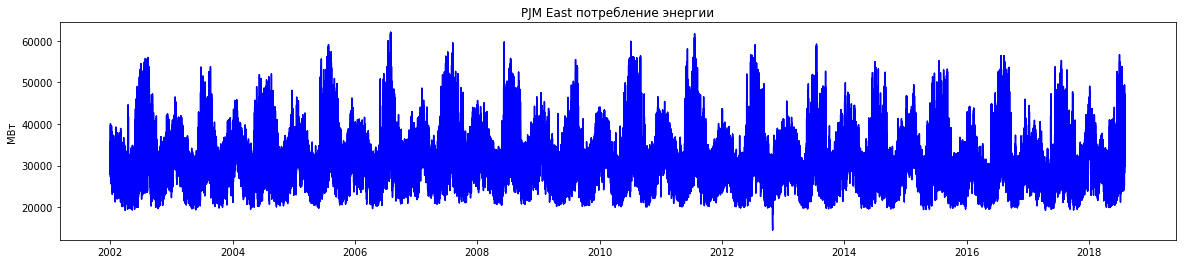

In [3]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

Рис.1. Потребление энергии

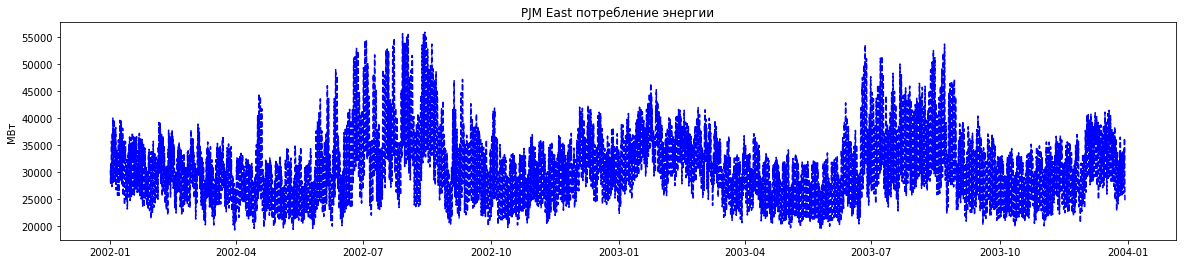

In [4]:
date_time =data['PJME_MW']
date_time.index = pd.date_range(data.index[0], periods=data.index.shape[0], freq="H")
plt.figure(figsize =(20,4))
plt.plot( date_time.index[:24*7*104], date_time.values[:24*7*104], '--b' )

plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [5]:
d_data = data['PJME_MW'].values[1:]-data['PJME_MW'].values[:-1]

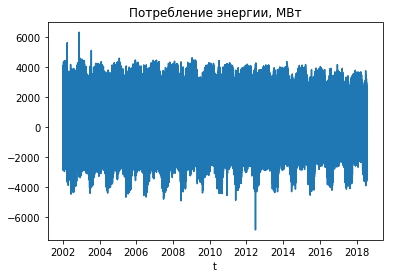

In [8]:
plt.plot(data.iloc[:-1].index,d_data)
plt.xlabel('t')
plt.title('Потребление энергии, МВт')
plt.show()

In [9]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

Обращаемся к тесту с параметром regression='ctt' - анализировать на постоянные составляющие , линейные и квадратичные тренды.  Первый параметр должен содержать одномерный массив или Series

In [11]:
DF_data_d = sm.tsa.stattools.adfuller(d_data,regression='ctt')
print('коэффициент ADF для 1-й разности потребления энергии: ', DF_data_d[1])

коэффициент ADF для 1-й разности потребления энергии:  0.0


In [12]:
d_data=data.resample('D').mean()

In [13]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

Text(0.5, 1.0, 'PJME_MW')

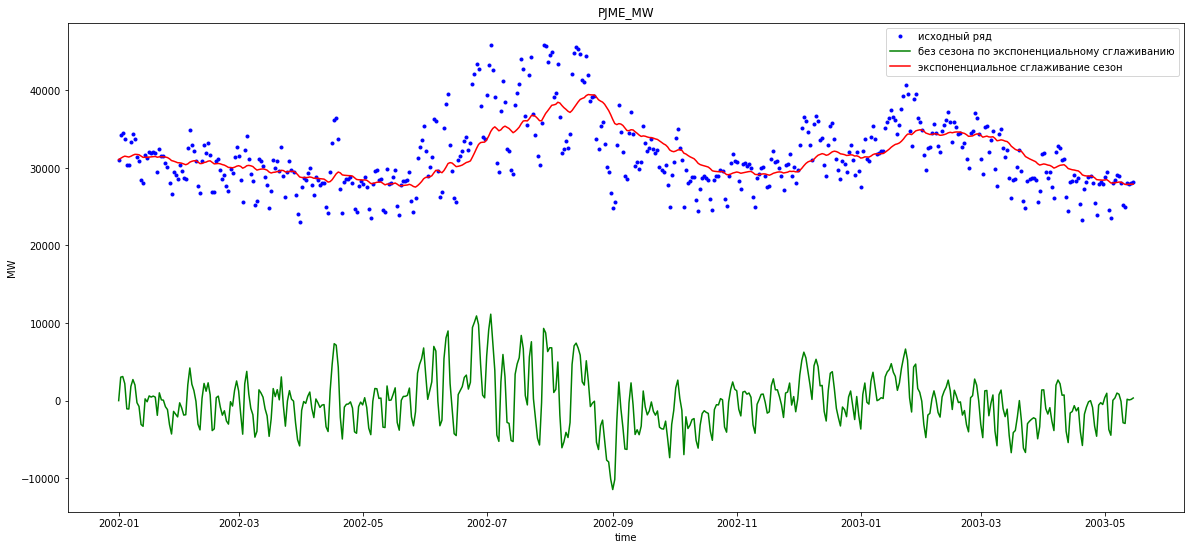

In [14]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW']  , 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [15]:
data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) -data_exp_1))
DF_ = sm.tsa.stattools.adfuller( data_seson_free.iloc[:,0] , regression = 'ctt')
DF_

(-8.36536213857042,
 4.282974615190959e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

Результат удаления явно сезонной составляющей для потребления энергии стационарный ряд. Перейдем к формированю пространства признаков, которое приблизит нас к цели - предсказанию следующего значения ряда.

In [16]:
e_ar = d_data['PJME_MW'].values
e_s = pd.DataFrame(data = d_data[['PJME_MW']])
e_s.shape

(6059, 1)

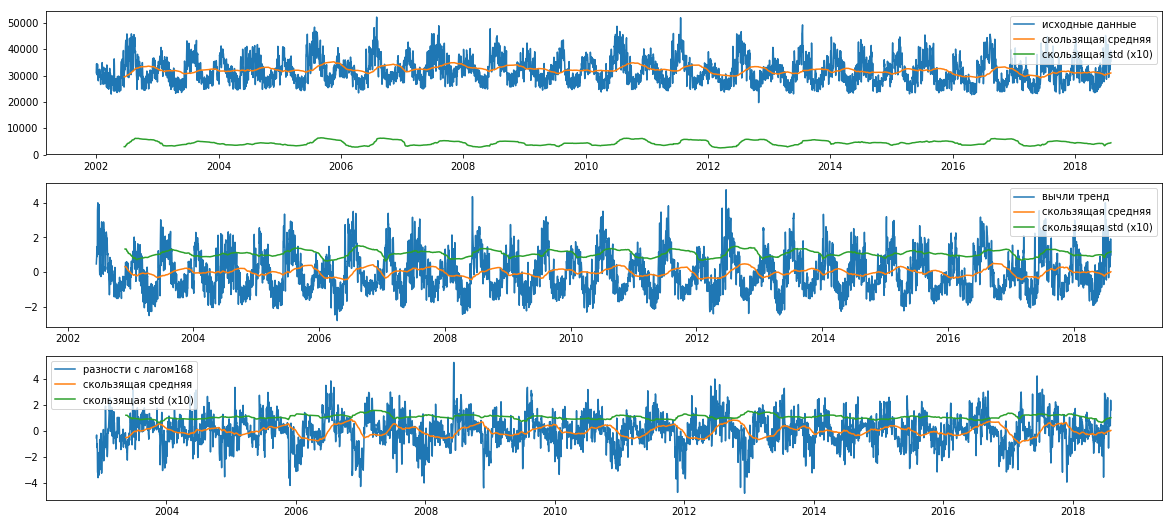

In [17]:
#import matplotlib.dates as mdates
train = e_s.iloc[:-10, :]
test = e_s.iloc[-10:, :]


N2 = 24*7

e_s['z_data'] = (e_s['PJME_MW'] - e_s['PJME_MW'].rolling(window=N2).mean()) / e_s['PJME_MW'].rolling(window=N2).std()
e_s['zp_data'] = e_s['z_data'] - e_s['z_data'].shift(N2)

def plot_rolling(e_s):
    fig, ax = plt.subplots(3,figsize=(20, 9))
    ax[0].plot(e_s.index, e_s['PJME_MW'], label='исходные данные')
    ax[0].plot(e_s['PJME_MW'].rolling(window=N2).mean(), label="скользящая средняя");
    ax[0].plot(e_s['PJME_MW'].rolling(window=N2).std(), label="скользящая std (x10)");
    ax[0].legend()

    ax[1].plot(e_s.index,e_s.z_data, label="вычли тренд")
    ax[1].plot(e_s.z_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[1].plot(e_s.z_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[1].legend()

    ax[2].plot(e_s.index, e_s.zp_data, label="разности с лагом" +str(N2))
    ax[2].plot(e_s.zp_data.rolling(window=N2).mean(), label="скользящая средняя");
    ax[2].plot(e_s.zp_data.rolling(window=N2).std(), label="скользящая std (x10)");
    ax[2].legend()

    #plt.tight_layout()
   #
    plt.show()
plot_rolling(e_s)

In [18]:
data_exp_1 = pd.DataFrame(data = data_exp_1, index = e_s.index)
#без тренда 
brent_data_trend_free = (e_s['PJME_MW'] - data_exp_1.iloc[:,0])
brent_data_trend_free.head()
DF_brent = sm.tsa.stattools.adfuller(brent_data_trend_free , regression = 'ctt')
DF_brent

(-8.581319663378363,
 1.2647533241293718e-11,
 33,
 6025,
 {'1%': -4.37305434095676,
  '5%': -3.8333705437821584,
  '10%': -3.5538675485903948},
 107068.01402251713)

In [19]:
df= pd.DataFrame(data_exp_1)
df.head()
 # добавили историю на глубину 3 измерения от текущего (р=3)
df['t'] = 0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t1']=0
df.iloc[2:,2]=df.iloc[:-2,0].values
df['t2']=0
df.iloc[3:,3]=df.iloc[:-3,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0
df['diff1'].iloc[1:] = df.iloc[:-1,0]-df.iloc[1:,0]


df.head()

C:\Users\a.andoskin\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,0,t,t1,t2,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.0
2002-01-02,31239.779257,31080.739130,0.000000,0.000000,31082.329532,31085.510334,31093.462341,0.0
2002-01-03,31403.384044,31239.779257,31080.739130,0.000000,31085.540077,31095.046546,31118.256077,0.0
2002-01-04,31518.987759,31403.384044,31239.779257,31080.739130,31089.874554,31107.764782,31150.314611,0.0
2002-01-05,31463.294621,31518.987759,31403.384044,31239.779257,31093.608754,31118.430677,31175.353012,0.0


In [20]:
df.columns

Index([0, 't', 't1', 't2', 'exp_0_01', 'exp_0_03', 'exp_0_08', 'diff1'], dtype='object')

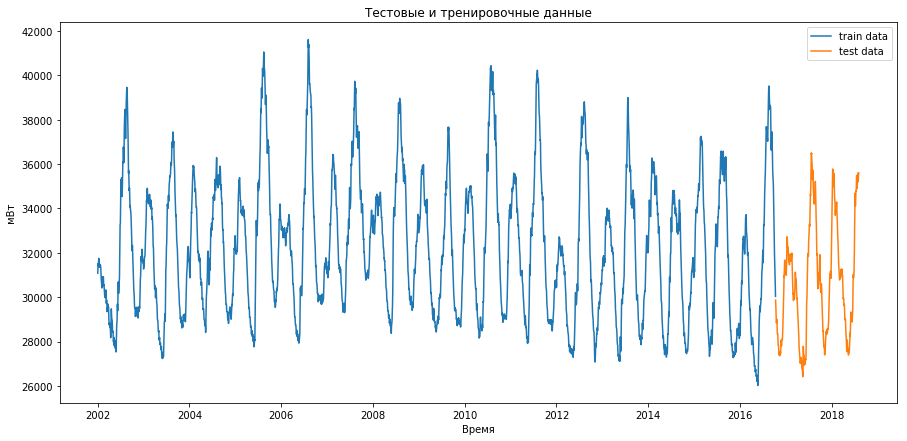

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
scl =StandardScaler()
scly =StandardScaler()

# сделаем примеры и модель 
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train_b, test_b = split_data_b( df, '10-10-2016')

X_train_b = train_b.iloc[:-1,:]
y_train_b = train_b[df.columns[0]].values[1:]
X_test_b = test_b.iloc[:-1,:]
y_test_b = test_b[df.columns[0]].values[1:]


plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel(' мВт ')
plt.plot(train_b.index.get_level_values('Date'),train_b[df.columns[0]], label='train data' )
plt.plot(test_b.index.get_level_values('Date'),test_b[df.columns[0]], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

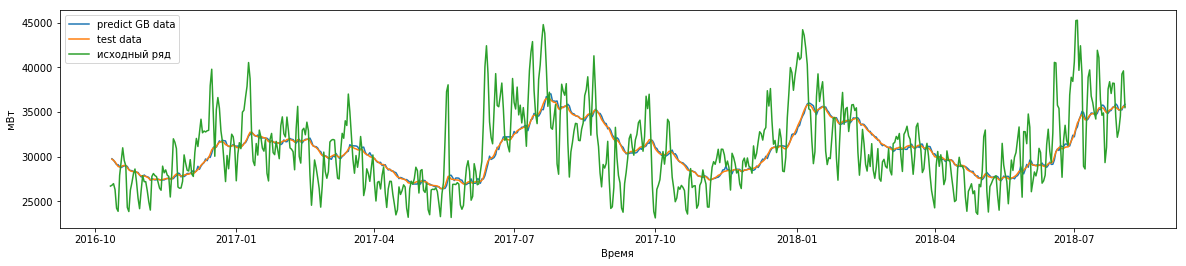

ошибка градиентного бустинга :   0.47608976387157564 %


In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)
model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel(' мВт ')
plt.plot(test_b.index[1:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[1:],y_test_b, label='test data')
plt.plot(e_s.loc['2016-10-11':].index, e_s.loc['2016-10-11':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

Модель авторегрессии с горизонтом прогноза 1 (т.е. считаем на один шаг вперед) работает замечательно на всем интервале теста. Значение ошибки для нее не превышает 0.5%. Однако моделируем только нестационарный процесс и на коротком интервале прогноза. увеличим интервал прогноза до 10 шагов вперед. 

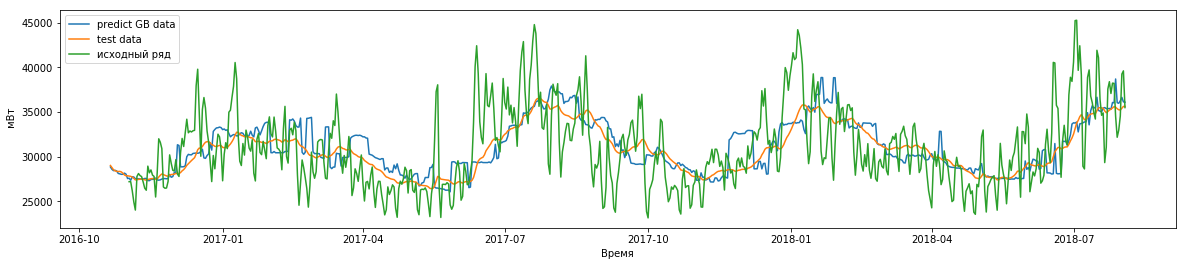

ошибка градиентного бустинга :   3.473005499339311 %


In [23]:
h=10
X_train_b = train_b.iloc[:-h,:]
y_train_b = train_b[df.columns[0]].values[h:]
X_test_b = test_b.iloc[:-h,:]
y_test_b = test_b[df.columns[0]].values[h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel(' мВт')
plt.plot(test_b.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test_b.index[h:],y_test_b, label='test data')
plt.plot(e_s.loc['2016-11-02':].index, e_s.loc['2016-11-02':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')


Все стало не так хорошо (почти 3.5% ошибки по основной линии прогноза и много по реальному ряду)

3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

Ошибка модели изменилась значительно, возможно, это связано с тем, что если мы предасказываем на 10 шагов вперед, то вносим большую погрешность в будующие значения, т.к. не достаточно информации только о отренде для предсказаний

4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени

а) Изменение температуры за окном
Если в течении года, то будет тренд, т.к. значение температуры будет меняться значительно. Например, летом +30 максимум, а зимой -30 максимум. Будет сезоность, т.к. будут времена года. Будут циклы, т.к. погода меняется циклично от утра до утра

б) Количество денег, которые тратят покупатели в интернет магазине.
Здесь явно будет тренд, который будет зависить от многих факторов, например, рекламы.
Возможно, будет сезонность, если это магазин, который продает новогодние подарки

в) Вес растущего котенка
Если берем отрезок времени год, то будет наблюдаться тренд, т.к. котенок растет и набирает вес.
Если мы делаем измерения каждый час, то увидим еще дневной цикл колебаний веса, т.к. котенок будет набирать вес после еды, и он будет уменьшаться до следующего приема пищи
    
г) Прирост объема деревьев в лесу от времени
Будет тренд, если, например, в лесу ведется выпрубка и не высаживаются деревья
Возможно, будет сезонность, т.к. зимой сложнее рубить и доставлять лес, чем летом